In [1]:
!pip install --quiet pmdarima==1.8.5 imbalanced-learn==0.11.0 xgboost==1.7.6


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 639.7/639.7 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 4.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pmdarima
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pmdarima)


In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler, scale
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
from l0bnb import fit_path
import statsmodels.api as sm
from tqdm import tqdm
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')
import itertools
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

In [4]:

np.random.seed(22)

n = 1000
p = 20
X = np.random.normal(size=(n, p))

error = np.random.normal(size=n)
b1 = np.random.normal(size=p)

b1[9] = 0
b1[6] = 0
b1[3] = 0

y = np.dot(X, b1) + error

In [5]:
data = pd.DataFrame(X, columns=[f"Feature_{i}" for i in range(1, 21)])
data['Target'] = y

data.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Target
0,-0.091950,-1.463351,1.081792,-0.239325,-0.491129,-1.002272,0.918822,-1.103632,0.626493,-0.561514,...,-0.230767,0.587752,0.752318,-1.058503,1.055972,0.747750,1.064677,1.520130,-1.488603,-1.019465
1,1.859990,-1.598613,-0.646074,0.337325,1.046729,0.629143,0.363059,0.555750,-1.088550,0.023695,...,-2.490030,-0.234862,-0.097563,-0.886529,-0.136713,0.101979,-0.250930,-0.078812,-1.085164,1.437071
2,0.594928,-0.638908,-1.107837,2.106146,-0.567388,-0.479950,-1.923230,0.399589,-1.048184,-0.693879,...,0.536910,-0.732722,0.555716,0.432289,-0.135804,-0.941106,0.484767,-1.532821,0.404979,-0.359385
3,0.012826,-1.231716,-1.053085,2.516222,-2.039029,0.094487,-0.314823,0.490315,0.354976,0.950711,...,0.011504,-1.376057,-0.271555,0.542252,0.535522,1.159998,-0.165005,-1.179403,-0.545299,-1.349660
4,0.270503,0.980238,1.006888,0.782156,-1.248592,-0.423833,0.552608,0.329603,0.863118,-1.227378,...,-2.769533,-0.492178,0.069148,-0.350003,0.869345,-0.216764,0.017118,0.689713,-0.883143,-2.619771


In [6]:
X = data.drop(['Target'], axis=1)
y = data.Target

In [7]:

X_train, X_test, y_train, y_test = train_test_split(data.drop(['Target'], axis=1), data.Target, test_size=0.9)

Text(0, 0.5, 'Training MSE')

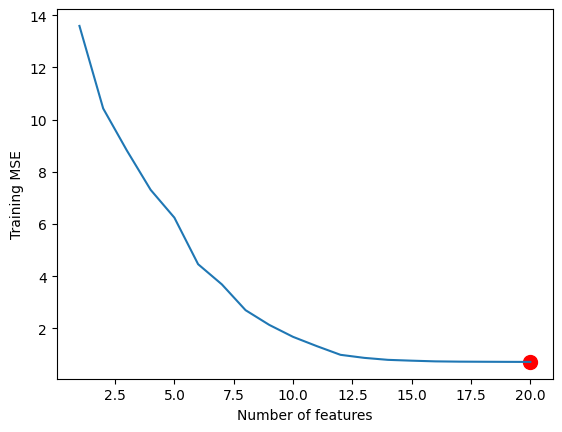

In [8]:
oldxs  = []
xcombo = []
coef   = []
mse    = []
ssr    = []
err    = []

remainx = X_train

for i in range(1, p+1):

    best_ssr = np.inf

    for combo in itertools.combinations(remainx.columns,1):
        tempx = sm.add_constant(X_train[oldxs + list(combo)])
        lm    = sm.OLS(y_train,tempx).fit()

        if lm.ssr < best_ssr:
            addx       = list(combo)[0]
            best_coef  = list(lm.params)
            best_mse   = ((lm.predict(tempx)-y_train)**2).mean()
            best_ssr   = lm.ssr
            temp_xtest = sm.add_constant(X_test[tempx.columns[1:]])
            test_mse   = ((lm.predict(temp_xtest)-y_test)**2).mean()

    oldxs.append(addx)
    remainx = X_train.drop(labels=list(oldxs), axis=1)

    xcombo.append(oldxs.copy())
    coef.append(best_coef)
    mse.append(best_mse)
    ssr.append(best_ssr)
    err.append(test_mse)

results = pd.DataFrame({'xnum':range(1,p+1), 'xcombo':xcombo, 'coef':coef,
                        'MSE':mse, 'RSS':ssr})

# Training MSE
min_mse = results.MSE.min()
plt.plot(range(1,p+1), results['MSE'])
plt.scatter(results.MSE.idxmin()+1, min_mse, s=100, c='r')
plt.xlabel('Number of features')
plt.ylabel('Training MSE')

Text(0, 0.5, 'Test MSE')

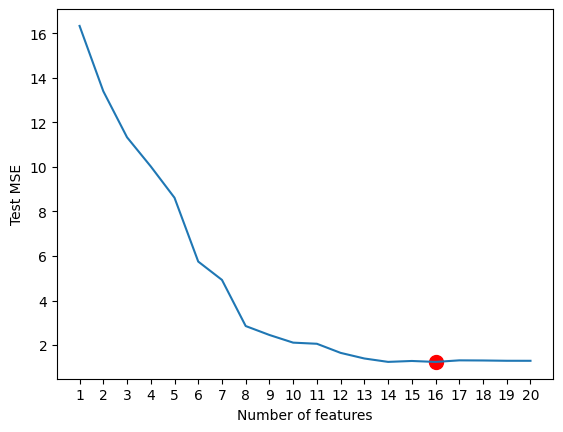

In [9]:
plt.plot(range(1,p+1), err)
plt.scatter(err.index(min(err))+1, min(err), s=100, c='r')
plt.xticks(np.arange(1, 21, step=1))
plt.xlabel('Number of features')
plt.ylabel('Test MSE')

In [10]:
best_xcombo = results[results['xnum']==(err.index(min(err))+1)].xcombo
for i in best_xcombo:
  print(i)
best_coef   = results[results['xnum']==(err.index(min(err))+1)].coef
print(best_coef.values.reshape(-1,1))
print(b1)

['Feature_12', 'Feature_3', 'Feature_20', 'Feature_8', 'Feature_19', 'Feature_14', 'Feature_1', 'Feature_11', 'Feature_17', 'Feature_15', 'Feature_6', 'Feature_9', 'Feature_16', 'Feature_13', 'Feature_10', 'Feature_18']
[[list([-0.11828484037405362, 1.626202334419741, 1.706003123724524, 1.2126878781059331, 1.1043848642928644, 1.1347505058788792, -1.4771166417531176, 0.8252820043951885, 1.5244376290409274, 0.5221464910366211, -0.7485615241636644, 0.511803591933964, -0.6933657946003557, 0.3548765673297781, -0.2677785757536099, 0.19025188063990822, 0.18020789403262483])]]
[ 0.85492837  0.06080148  1.6365729   0.          0.10995585  0.39193698
  0.          0.98111446 -0.69174145  0.          1.41789765  1.52286808
 -0.27029689 -1.53423822 -0.60778128  0.39712937  0.49767799  0.19767749
  1.3263032   1.37162124]


([<matplotlib.axis.XTick at 0x78b390a96a10>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

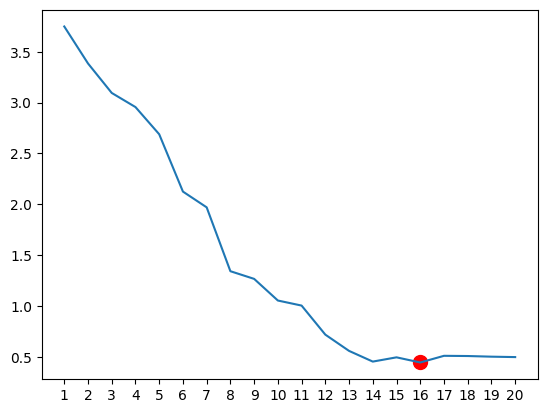

In [11]:
values = []
dfb = pd.DataFrame({'b':b1}, index=[f"Feature_{i}" for i in range(1, 21)])
for r in range(0,p):
    dfc = pd.DataFrame({'coef':results.coef[r][1:]}, index=results.xcombo[r])
    df  = pd.merge(dfb, dfc, how="outer", left_index=True, right_index=True).fillna(0)
    values.append((sum((df.b-df.coef)**2))**0.5)

plt.plot(np.arange(1,21), values)
plt.scatter(x = values.index(min(values))+1, y = min(values), s=100, c='r')
plt.xticks(np.arange(1, 21, step=1))

In [12]:
Boston = load_data("Boston")
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [13]:
X = Boston.drop(['crim'], axis=1)
y = Boston.crim

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [14]:
alphas = np.logspace(-4, 0, 100)

ridgecv = RidgeCV(alphas=alphas, store_cv_values=True)
ridgecv.fit(X_train, y_train)

print(ridgecv.alpha_)

1.0


In [15]:
MSE_values = np.mean(ridgecv.cv_values_, axis=0)
min_MSE = np.min(MSE_values)
min_MSE

17.009947966071834

In [16]:
pd.Series(ridgecv.coef_.flatten(), index=X_train.columns)

,0
zn,0.031981
indus,-0.072470
chas,-1.019661
nox,-2.165566
rm,0.098085
age,-0.008426
dis,-0.653405
rad,0.507318
tax,-0.002405
ptratio,-0.114313


In [17]:
lassocv = LassoCV(alphas=alphas, cv=10, max_iter=1000)
lassocv.fit(X_train, y_train)

print(lassocv.alpha_)

0.08111308307896872


In [18]:
mses = np.mean(lassocv.mse_path_, axis=1)
min_mse = np.min(mses)
min_mse

16.875192143628183

In [19]:
pd.Series(lassocv.coef_.flatten(), index=X_train.columns)

,0
zn,0.030910
indus,-0.079241
chas,-0.000000
nox,-0.000000
rm,0.000000
age,-0.008191
dis,-0.546278
rad,0.488855
tax,-0.001592
ptratio,-0.051628


In [20]:
scores = []

scores.append(-np.mean(cross_val_score(LinearRegression(), np.ones((X.shape[0], 1)),
                                     y, cv=5, scoring='neg_mean_squared_error')))

for i in np.arange(1, X.shape[1]+1):
    scaler = StandardScaler()
    X_ = scaler.fit_transform(X)

    pca = PCA(n_components=i)
    X_pcr = pca.fit_transform(X_)

    score = -np.mean(cross_val_score(LinearRegression(), X_pcr[:, :i],
                                    y, cv=5, scoring='neg_mean_squared_error'))

    scores.append(score)

In [21]:
print(np.argmin(scores))
print(np.min(scores))

7
45.97819271836653


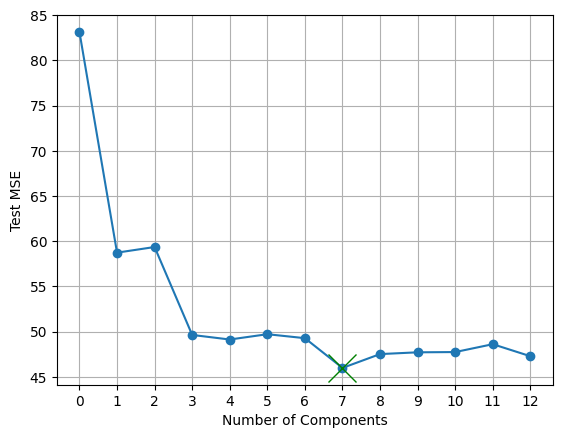

In [22]:
plt.plot(scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Test MSE')
plt.xticks(np.arange(0, X_train.shape[1]+1, 1))

plt.plot(np.argmin(scores), np.min(scores), 'gx', markersize=20)
plt.grid()

In [23]:
College = load_data("College")
College = pd.get_dummies(College, columns = ['Private']).drop(['Private_No'], axis=1)
College.head()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private_Yes
0,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,True
1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,True
2,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,True
3,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,True
4,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,True


In [24]:
X_train, X_test, y_train, y_test = train_test_split(College.drop(['Apps'], axis=1), College.Apps, test_size=0.5, random_state=1)

In [25]:
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(X_train, y_train)

mean_squared_error(y_test, linear_model.predict(X_test))

1425055.5873112094

In [26]:
alphas = np.logspace(-4, 0, 100)

ridgecv = RidgeCV(alphas=alphas, store_cv_values=True)
ridgecv.fit(X_train, y_train)

print(ridgecv.alpha_)

1.0


In [27]:
MSE_values= np.mean(ridgecv.cv_values_, axis=0)
min_MSE = np.min(MSE_values)
print(min_MSE)

1291210.5443199957


In [28]:
lassocv = LassoCV(alphas=alphas, cv=10, max_iter=1000)
lassocv.fit(X_train, y_train)

print(lassocv.alpha_)

1.0


In [29]:
MSE_values = np.mean(lassocv.mse_path_, axis=1)
min_MSE = np.min(MSE_values)
print(min_MSE)

1284070.961863224


In [30]:
pd.Series(lassocv.coef_.flatten(), index=X_train.columns)

,0
Accept,1.142031
Enroll,0.487827
Top10perc,62.755205
Top25perc,-22.697526
F.Undergrad,-0.006027
P.Undergrad,0.016660
Outstate,-0.067307
Room.Board,0.247246
Books,-0.206702
Personal,-0.085643


### Part 3.5

In [31]:

scores = []
scores.append(-np.mean(cross_val_score(LinearRegression(), np.ones((X_train.shape[0], 1)),
                                     y_train, cv=5, scoring='neg_mean_squared_error')))

for i in np.arange(1, X_train.shape[1]+1):
    scaler = StandardScaler()
    X_ = scaler.fit_transform(X_train)

    pca = PCA(n_components=i)
    X_pcr = pca.fit_transform(X_)

    score = -np.mean(cross_val_score(LinearRegression(), X_pcr[:, :i],
                                    y_train, cv=5, scoring='neg_mean_squared_error'))

    scores.append(score)

In [32]:
print(np.argmin(scores))
print(np.min(scores))

16
1312200.0054480808


### Part 3.6

In [33]:
scores_pls = []
for i in np.arange(1, X_train.shape[1]+1):
    score = -np.mean(cross_val_score(PLSRegression(n_components=i),
                                    scale(X_train), y_train,
                                    cv=5, scoring='neg_mean_squared_error'))

    scores_pls.append(score)

In [34]:
print(np.argmin(scores_pls))
print(np.min(scores_pls))

9
1312383.003837396


In [35]:
College["Apps"].mean()

3001.6383526383524